# Neighborhood analysis of the Florianópolis - SC - Brazil
## This study analysis and clusters the neighborhoods of the city of Florianopolis, southern Brazil
Luis Lamas - may-2021

Import relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
import requests
import re
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN 
import matplotlib.cm as cm
import matplotlib.colors as colors

pd.set_option('display.max_rows', None)


## Webscrape Neighborhood names from Wikipedia
https://pt.wikipedia.org/wiki/Lista_de_distritos_e_bairros_de_Florian%C3%B3polis

Retrieve the names of Neighborhoods in Florianópolis from Wikipedia

In [2]:
url = 'https://pt.wikipedia.org/wiki/Lista_de_distritos_e_bairros_de_Florian%C3%B3polis'
data  = requests.get(url).text 
soup = BeautifulSoup(data,"html5lib")  

In [3]:
df_city = pd.DataFrame(columns=["Neighborhood"])

tables = soup.findAll('table')

for table_aux in tables:
    table_caption = table_aux.find('caption')
    if table_caption is not None:
        if table_caption.text.find('População dos bairros de Florianópolis') != -1:
            table = table_aux

for row in table.find_all('tr'): # in html table row is represented by the tag <tr>
    # Get all columns in each row.
    cols = row.find_all('td') # in html a column is represented by the tag <td>
    cont = 0
    for col in cols:
        col.get_text(strip=True)
        aux_text = [text for text in col.stripped_strings]
        cont = cont + 1
        if cont == 2:
            neighborhood = aux_text[0]
            df_city = df_city.append({"Neighborhood":neighborhood}, ignore_index=True)
 
df_city.head()

,Neighborhood
0,Centro
1,Capoeiras
2,Trindade
3,Agronômica
4,Saco dos Limões


In [27]:
df_city.shape

(85, 1)

## Retrieve Latitude and Longitude for the city and each neighborhood

Use geopy and Nominatim to retrieve geographical information (Latitude and Longitude)

In [4]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Florianópolis Brazil'
geolocator = Nominatim(user_agent="floripa")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Florianópolis are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Florianópolis are -27.5973002, -48.5496098.


In [5]:
df_geolocations = pd.DataFrame(columns=['Neighborhood', 'Latitude', 'Longitude'])

for i in range(len(df_city)):
    neigh = df_city.Neighborhood.iloc[i]
    query = '{}, Florianópolis, Brasil'.format(neigh)
    
    location = geolocator.geocode(query)
    try:
        latitude = location.latitude
        longitude = location.longitude
        df_geolocations = df_geolocations.append({'Neighborhood':neigh, 'Latitude':latitude, 'Longitude':longitude}, ignore_index=True)
    except:
        latitude = -1
        longitude = -1
    print(neigh, end=', ')

Centro, Capoeiras, Trindade, Agronômica, Saco dos Limões, Coqueiros, Monte Cristo, Jardim Atlântico, Itacorubi, Costeira do Pirajubaé, Capivari, Tapera da Base, Estreito, Monte Verde, Balneário, São João do Rio Vermelho, Canto, Abraão, Santa Mônica, Lagoa, Saco Grande, Córrego Grande, Canasvieiras, Pantanal, Coloninha, Barra da Lagoa, Carianos, José Mendes, Ingleses Centro, João Paulo, Campeche Leste, Campeche Sul, Rio Tavares Central, Santinho, Ponta das Canas, Vargem do Bom Jesus, Armação, Cachoeira do Bom Jesus Leste, Pântano do Sul, Itaguaçu, Jurere Leste, Campeche Norte, Vargem Grande, Campeche Central, Ressacada, Morro das Pedras, Alto Ribeirão Leste, Alto Ribeirão, Ribeirão da Ilha, Santo Antônio, Sambaqui, Ingleses Sul, Bom Abrigo, Jurere Oeste, Porto da Lagoa, Cachoeira do Bom Jesus, Rio Tavares do Norte, Pedregal, Ratones, Canto da Lagoa, Retiro, Cacupé, Lagoa Pequena, Barra do Sambaqui, Caiacanga, Lagoinha do Norte, Base Aérea, Pedrita, Açores, Costeira do Ribeirão, Moenda, 

# Correct values unproperly retrieved
This step is necessary because not all queries returned correct position. Values were retrieved manually

In [6]:
neighs_to_correct = ['Centro', 'Retiro', 'Santo Antônio', 'Ressacada']

idx = df_geolocations.index[df_geolocations['Neighborhood'] == 'Centro']
df_geolocations.loc[idx, 'Latitude'] = -27.5972029
df_geolocations.loc[idx, 'Longitude'] = -48.5494815

idx = df_geolocations.index[df_geolocations['Neighborhood'] == 'Retiro']
df_geolocations.loc[idx, 'Latitude'] = -27.6125
df_geolocations.loc[idx, 'Longitude'] = -48.4475

idx = df_geolocations.index[df_geolocations['Neighborhood'] == 'Santo Antônio']
df_geolocations.loc[idx, 'Latitude'] = -27.5107
df_geolocations.loc[idx, 'Longitude'] = -48.5125

idx = df_geolocations.index[df_geolocations['Neighborhood'] == 'Ressacada']
df_geolocations.loc[idx, 'Latitude'] = -27.6665
df_geolocations.loc[idx, 'Longitude'] = -48.5317


## Print map of Florianopolis with neighborhoods
Use folium to print map of Florianópolis, with its neighborhoods

In [7]:
import folium
# create map using latitude and longitude values
map_city = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df_geolocations['Latitude'], df_geolocations['Longitude'], df_geolocations['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city)  
    
map_city

## Explore the Neighboorhoods using Foursquare API

In [8]:
CLIENT_ID = '4JSGKADZIJ1DKEXHDWZ5GNHJ44H2PTS0ONXGS3SI2PI3S3UQ' # your Foursquare ID
CLIENT_SECRET = 'IX5K5P4XBYKILUP5RRPPR10Q05YVJPYXJNGQFYR0E3CA02P0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name, end=', ')
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
city_venues = getNearbyVenues(names=df_geolocations['Neighborhood'],
                                   latitudes=df_geolocations['Latitude'],
                                   longitudes=df_geolocations['Longitude']
                                  )

Centro, Capoeiras, Trindade, Agronômica, Saco dos Limões, Coqueiros, Monte Cristo, Jardim Atlântico, Itacorubi, Costeira do Pirajubaé, Capivari, Tapera da Base, Estreito, Monte Verde, Balneário, São João do Rio Vermelho, Canto, Abraão, Santa Mônica, Lagoa, Saco Grande, Córrego Grande, Canasvieiras, Pantanal, Coloninha, Barra da Lagoa, Carianos, José Mendes, Ingleses Centro, João Paulo, Campeche Leste, Campeche Sul, Rio Tavares Central, Santinho, Ponta das Canas, Vargem do Bom Jesus, Armação, Cachoeira do Bom Jesus Leste, Pântano do Sul, Itaguaçu, Jurere Leste, Vargem Grande, Campeche Central, Ressacada, Morro das Pedras, Alto Ribeirão Leste, Alto Ribeirão, Ribeirão da Ilha, Santo Antônio, Sambaqui, Ingleses Sul, Bom Abrigo, Jurere Oeste, Porto da Lagoa, Cachoeira do Bom Jesus, Pedregal, Ratones, Canto da Lagoa, Retiro, Cacupé, Barra do Sambaqui, Caiacanga, Lagoinha do Norte, Base Aérea, Pedrita, Açores, Costeira do Ribeirão, Tapera, Daniela, Vargem Pequena, Canto dos Araçás, Recanto do

In [11]:
city_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centro,-27.597203,-48.549481,Tralharia,-27.598638,-48.548866,Antique Shop
1,Centro,-27.597203,-48.549481,Keko Pastelaria,-27.595751,-48.550234,Pastelaria
2,Centro,-27.597203,-48.549481,Livrarias Catarinense,-27.597298,-48.550745,Bookstore
3,Centro,-27.597203,-48.549481,Catedral Metropolitana de Florianópolis,-27.596761,-48.549521,Church
4,Centro,-27.597203,-48.549481,Falah Coffee Store,-27.595888,-48.551166,Coffee Shop


## Create a column of General Cathegory, to look for Restaurants, Bars, Hotels and Beaches

In [12]:
def classifier(row):
    
    list_txt = ['Restaurant', 'Coffee', 'Café', 'Buffet', 'Bistro', 'Burger', 'Food', 'BBQ', 'Taco']
    for venue_type in list_txt:
        if row['Venue Category'].find(venue_type) != -1:
            return 'Restaurant'
        
    list_txt = ['Club', 'Pub', 'Bar', 'Nightclub', 'Beer', 'Brewery']
    for venue_type in list_txt:
        if row['Venue Category'].find(venue_type) != -1:
            return 'Bar'

    list_txt = ['Hostel', 'Hotel', 'Bed & Breakfast']
    for venue_type in list_txt:
        if row['Venue Category'].find(venue_type) != -1:
            return 'Hotel'                
        
    list_txt = ['Beach']
    for venue_type in list_txt:
        if row['Venue Category'].find(venue_type) != -1:
            return 'Beach'        
        
city_venues['General Category'] = city_venues.apply(classifier, axis=1)

In [13]:
city_venues.head(5)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,General Category
0,Centro,-27.597203,-48.549481,Tralharia,-27.598638,-48.548866,Antique Shop,None
1,Centro,-27.597203,-48.549481,Keko Pastelaria,-27.595751,-48.550234,Pastelaria,None
2,Centro,-27.597203,-48.549481,Livrarias Catarinense,-27.597298,-48.550745,Bookstore,None
3,Centro,-27.597203,-48.549481,Catedral Metropolitana de Florianópolis,-27.596761,-48.549521,Church,None
4,Centro,-27.597203,-48.549481,Falah Coffee Store,-27.595888,-48.551166,Coffee Shop,Restaurant


In [14]:
city_venues_categorized = city_venues.copy()
idx = city_venues.index[pd.isna(city_venues['General Category'])]
city_venues_categorized.drop(idx, axis=0, inplace=True)
city_venues_categorized.reset_index(drop=True, inplace=True)
city_venues_categorized.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,General Category
0,Centro,-27.597203,-48.549481,Falah Coffee Store,-27.595888,-48.551166,Coffee Shop,Restaurant
1,Centro,-27.597203,-48.549481,Cia Sucos,-27.596525,-48.548087,Juice Bar,Bar
2,Centro,-27.597203,-48.549481,Alcatéia Restaurante,-27.597204,-48.547697,Brazilian Restaurant,Restaurant
3,Centro,-27.597203,-48.549481,XKebab,-27.598972,-48.549257,Middle Eastern Restaurant,Restaurant
4,Centro,-27.597203,-48.549481,Central Restaurante,-27.595199,-48.550773,Buffet,Restaurant


## Create a dataframe for City Summary

In [15]:
city_summary = pd.DataFrame(columns = ['Neighborhood', 'Latitude', 'Longitude', 'Restaurants', 'Bars', 'Hotels', 'Beaches'])


In [16]:
neigh = 'Centro'

for neigh in city_venues_categorized['Neighborhood'].unique():

    idx = city_venues_categorized.index[city_venues_categorized['Neighborhood'] == neigh]
    df_aux = city_venues_categorized[city_venues_categorized['Neighborhood'] == neigh]
    latitude = city_venues_categorized.loc[idx[0], 'Neighborhood Latitude']
    longitude = city_venues_categorized.loc[idx[0], 'Neighborhood Longitude']
    restaurants = df_aux[df_aux['General Category'] == 'Restaurant'].count()
    bars = df_aux[df_aux['General Category'] == 'Bar'].count()
    hotels = df_aux[df_aux['General Category'] == 'Hotel'].count()
    beaches = df_aux[df_aux['General Category'] == 'Beach'].count()

    city_summary = city_summary.append({'Neighborhood':neigh, 'Latitude':latitude, 'Longitude':longitude, 'Restaurants':restaurants[0], 'Bars':bars[0], 'Hotels':hotels[0], 'Beaches':beaches[0]}, ignore_index=True)


In [29]:
city_summary.head()

,Neighborhood,Latitude,Longitude,Restaurants,Bars,Hotels,Beaches,Cluster Labels
0,Centro,-27.597203,-48.549481,24,13,0,0,1
1,Capoeiras,-27.597333,-48.590008,3,0,0,0,0
2,Trindade,-27.589383,-48.522400,17,5,0,0,1
3,Agronômica,-27.578145,-48.535717,1,0,0,0,0
4,Saco dos Limões,-27.608268,-48.534343,2,0,0,0,0


## Cluster Neighborhoods
Determine optimum number of clusters for kmeans

C:\Users\22187335879\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


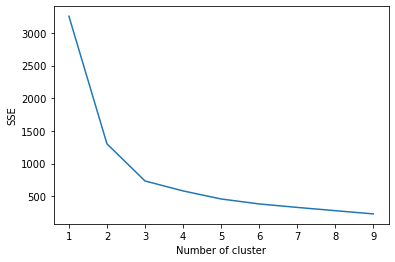

In [17]:
df_grouped_clustering = city_summary.copy()
df_grouped_clustering.drop(['Neighborhood', 'Latitude', 'Longitude'], axis=1, inplace=True)

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_grouped_clustering)
    #data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ 
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()    

From the graph above, it is possible to observe the "Elbow" for number of clusters = 3. So, we will use this value

In [18]:
kclusters = 3

df_grouped_clustering = city_summary.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

kmeans.labels_[0:10] 

array([1, 0, 1, 0, 0, 2, 0, 2, 0, 0])

In [19]:
city_summary['Cluster Labels'] = kmeans.labels_

## Create map with clusters

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_summary['Latitude'], city_summary['Longitude'], city_summary['Neighborhood'], city_summary['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Analyse Clusters

In [21]:
city_summary.loc[city_summary['Cluster Labels'] == 0].head()

,Neighborhood,Latitude,Longitude,Restaurants,Bars,Hotels,Beaches,Cluster Labels
1,Capoeiras,-27.597333,-48.590008,3,0,0,0,0
3,Agronômica,-27.578145,-48.535717,1,0,0,0,0
4,Saco dos Limões,-27.608268,-48.534343,2,0,0,0,0
6,Monte Cristo,-27.590583,-48.601635,2,2,0,0,0
8,Itacorubi,-27.581529,-48.504141,5,1,0,0,0


In [22]:
city_summary.loc[city_summary['Cluster Labels'] == 1].head()

,Neighborhood,Latitude,Longitude,Restaurants,Bars,Hotels,Beaches,Cluster Labels
0,Centro,-27.597203,-48.549481,24,13,0,0,1
2,Trindade,-27.589383,-48.522400,17,5,0,0,1
18,Santa Mônica,-27.589928,-48.509703,21,8,0,0,1
21,Canasvieiras,-27.429567,-48.460244,30,6,10,2,1
23,Barra da Lagoa,-27.574778,-48.425835,16,2,7,3,1


In [23]:
city_summary.loc[city_summary['Cluster Labels'] == 2].head()

,Neighborhood,Latitude,Longitude,Restaurants,Bars,Hotels,Beaches,Cluster Labels
5,Coqueiros,-27.611202,-48.580844,7,7,0,1,2
7,Jardim Atlântico,-27.575492,-48.596799,9,0,1,0,2
12,Estreito,-27.590914,-48.577702,11,4,1,0,2
14,Balneário,-27.579596,-48.581138,10,0,1,2,2
16,Canto,-27.586797,-48.586221,10,1,1,0,2


## It is possible to observe that Cluster 1 has more entertainment options. Let´s focus on the locations where there are beaches.

In [24]:
city_summary.loc[(city_summary['Cluster Labels'] == 1) & (city_summary['Beaches'] > 1)]

,Neighborhood,Latitude,Longitude,Restaurants,Bars,Hotels,Beaches,Cluster Labels
21,Canasvieiras,-27.429567,-48.460244,30,6,10,2,1
23,Barra da Lagoa,-27.574778,-48.425835,16,2,7,3,1
35,Itaguaçu,-27.614656,-48.591550,20,3,0,3,1


In [25]:
best_neighs = city_summary.loc[(city_summary['Cluster Labels'] == 1) & (city_summary['Beaches'] > 1)]
#best_neighs = best_neighs['Neighborhood']
#best_neighs.reset_index(drop=True)

In [26]:
#aux = city_venues[['Venue', 'Venue Category']][city_venues['Neighborhood'] == 'Itaguaçu']
def classifier2(row):
    counter = 0
    list_txt = ['Beer', 'beer']
    for venue_type in list_txt:
        if row['Venue Category'].find(venue_type) != -1:
            counter += 1
    return counter


for neigh in best_neighs['Neighborhood']:
    df_aux = city_venues[['Venue', 'Venue Category']][city_venues['Neighborhood'] == neigh]
    summation = df_aux.apply(classifier2, axis=1).sum()
    print('Neighborhood {} has {} venues related to Beer'.format(neigh, summation))
    #print(neigh)

Neighborhood Canasvieiras has 1 venues related to Beer
Neighborhood Barra da Lagoa has 1 venues related to Beer
Neighborhood Itaguaçu has 1 venues related to Beer


## As none of the neighborhoods have excessive Beer places, all of them are good options for opening the Craft Beer Taphouse.